In [242]:
import datetime as dt
import pandas as pd
import alphalens as al
import numpy as np
import alphalens as al
import cvxpy as cvx
import os
import sys
import time
import matplotlib.pyplot as plt
import matplotlib.style as style
from scipy.stats.stats import pearsonr
from scipy.stats.stats import spearmanr
from tqdm import tqdm
from scipy.stats import gaussian_kde
style.use('ggplot')
plt.rcParams['figure.figsize'] = (14,14)

mod_path = '/Users/richard.wuebker/Projects/price_data_utils'
if mod_path not in sys.path:
    sys.path.append(mod_path)

libs_path = '/Users/richard.wuebker/Projects/backtesting/libs'
if libs_path not in sys.path:
    sys.path.append(libs_path)

    
from risk_model import RiskModelPCA
from optimal_holdings import OptimalHoldingsCVX
    
from data_loader import DataLoader
from mp_historical_prices import HistoricalPrices

In [73]:
dl = DataLoader(prices_dir='../price_data_utils/prices', info_dir='../price_data_utils/info', 
                analysis_date_str='2019-08-07', cached_dir='../price_data_utils/cached')
dl.load_data()
data = dl.data

Prediction Date: 2019-08-09


In [74]:
hp = HistoricalPrices(prices_dir='../price_data_utils/prices', 
                      cached_dir='../price_data_utils/cached',
                      date_str='2019-08-09')
hp.get_prices()
prices = hp.prices

# look for duplicates
p = prices.reset_index()
p.loc[p.duplicated(subset=['Date', 'ticker'], keep='first')]

,index,Date,High,Low,Open,Close,Volume,Adj Close,ticker


In [75]:
prices.head()

,Date,High,Low,Open,Close,Volume,Adj Close,ticker
0,1990-01-02,17.947027,17.527565,17.557526,17.947027,626200.0,7.267582,KMB
1,1990-01-03,17.976990,17.827181,17.976990,17.887104,749200.0,7.243319,KMB
2,1990-01-04,17.976990,17.797220,17.857143,17.857143,439700.0,7.231189,KMB
3,1990-01-05,17.857143,17.617449,17.797220,17.737297,712500.0,7.182656,KMB
4,1990-01-08,17.917067,17.707335,17.737297,17.917067,495600.0,7.255455,KMB


In [76]:
def transform_prices(df, end_date_str):
    prices_temp = df.pivot(index='Date', columns='ticker', values='Adj Close')
    end_date = dt.datetime.strptime(end_date_str, '%Y-%m-%d')
    start_date = end_date - pd.DateOffset(years=5)
    prices_temp.index = pd.to_datetime(prices_temp.index)
    prices = prices_temp.loc[start_date:end_date]
    return prices.dropna(axis=1)
new_p = transform_prices(prices, '2016-01-05')

In [77]:
# to make the index of data we have with sector the same as in returns and prices

sector_data = data['sector']
index_ = sector_data.index.intersection(new_p.columns)
sector_data = sector_data.loc[index_]
p = new_p.loc[:, index_].copy() # to use only the stocks that are in sector_data
sectors = sector_data.unique()

In [78]:
returns = p.pct_change().drop(p.index[0])
print(returns.shape)
print(sector_data.shape)
print(p.shape)

(1257, 741)
(741,)
(1258, 741)


In [79]:
p.head()

ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,PGR,WAT,NNN,IEX,LRCX,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-05,16.319235,25.350000,50.676487,91.209999,692.690002,59.998005,28.536177,40.534866,70.415245,34.523262,...,14.976269,77.790001,17.154980,33.694031,43.528183,23.909542,14.824180,6.94250,151.752335,16.587673
2011-01-06,16.460661,25.750000,50.676487,89.559998,718.400024,62.723892,28.326279,40.797176,69.994743,34.397305,...,14.842355,76.050003,16.839489,33.711502,43.555824,23.958487,14.856651,6.83000,150.116272,16.470205
2011-01-07,16.476372,25.950001,50.264294,89.133331,735.150024,62.590939,28.334854,40.758602,70.200493,34.976746,...,14.686119,75.209999,16.681742,33.589188,43.472923,24.031902,14.669928,6.69375,148.875351,16.315643
2011-01-10,16.334949,26.200001,50.342079,90.526665,749.960022,62.932850,28.647541,41.267784,70.057358,35.111115,...,14.358768,74.680000,16.497704,33.807583,44.891319,24.553984,14.678050,6.90250,151.096298,16.290915
2011-01-11,16.405655,25.690001,50.715374,93.663330,751.900024,63.474232,29.354307,41.653553,72.347855,35.279057,...,14.336452,76.300003,16.333384,33.982292,45.572895,24.456089,14.507563,6.79875,152.874680,16.303284


In [80]:
p.tail()

ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,PGR,WAT,NNN,IEX,LRCX,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2015-12-29,24.640928,59.299999,66.267441,184.456665,1650.000000,141.577072,48.883698,29.317432,31.023300,45.610756,...,29.112070,136.169998,34.340061,73.815681,75.976669,35.107853,39.816341,41.125000,314.309814,29.093164
2015-12-30,24.427971,57.509998,65.351830,184.169998,1649.540039,140.273254,48.753433,29.024263,29.830099,45.245197,...,28.986509,135.639999,34.271770,73.255249,75.430962,35.071419,39.375340,40.480000,312.891907,29.008694
2015-12-31,24.099659,57.299999,64.807915,182.053329,1643.000000,139.751724,48.278931,29.077566,30.792358,44.842140,...,28.520142,134.580002,34.186417,72.770805,74.725288,34.515739,39.672337,40.305000,311.492279,28.831297
2016-01-04,23.616772,55.610001,63.629417,182.463333,1555.660034,137.626907,48.325451,29.886017,31.100277,44.710915,...,27.910280,130.350006,33.768162,71.944405,73.135201,34.415535,39.096333,39.830002,304.704834,28.451166
2016-01-05,23.509462,55.060001,63.892326,183.986664,1594.089966,137.800766,48.167278,30.179193,31.591042,44.542198,...,28.170368,129.809998,34.382748,71.241478,73.530373,33.559250,39.078335,40.075001,305.491516,28.755270


In [81]:
# create a risk model for 2011 data
returns_2011 = returns.loc[returns.index.year == 2011]
print(returns_2011.shape)
returns_2011.head()

(249, 741)


ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,PGR,WAT,NNN,IEX,LRCX,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-06,0.008666,0.015779,0.000000,-0.018090,0.037116,0.045433,-0.007356,0.006471,-0.005972,-0.003648,...,-0.008942,-0.022368,-0.018391,0.000519,0.000635,0.002047,0.002190,-0.016205,-0.010781,-0.007082
2011-01-07,0.000954,0.007767,-0.008134,-0.004764,0.023316,-0.002120,0.000303,-0.000946,0.002939,0.016846,...,-0.010526,-0.011045,-0.009368,-0.003628,-0.001903,0.003064,-0.012568,-0.019949,-0.008266,-0.009384
2011-01-10,-0.008583,0.009634,0.001548,0.015632,0.020146,0.005463,0.011035,0.012493,-0.002039,0.003842,...,-0.022290,-0.007047,-0.011032,0.006502,0.032627,0.021725,0.000554,0.031186,0.014918,-0.001516
2011-01-11,0.004328,-0.019466,0.007415,0.034649,0.002587,0.008603,0.024671,0.009348,0.032695,0.004783,...,-0.001554,0.021693,-0.009960,0.005168,0.015183,-0.003987,-0.011615,-0.015031,0.011770,0.000759
2011-01-12,0.011494,0.008174,0.021469,0.004342,0.018779,-0.010175,0.002043,0.005927,0.013975,0.014044,...,-0.002076,0.005898,-0.003622,0.013419,0.014956,0.006004,0.019026,0.011583,0.002171,0.008722


In [352]:
risk_model = RiskModelPCA(returns_2011, 20)

<BarContainer object of 20 artists>

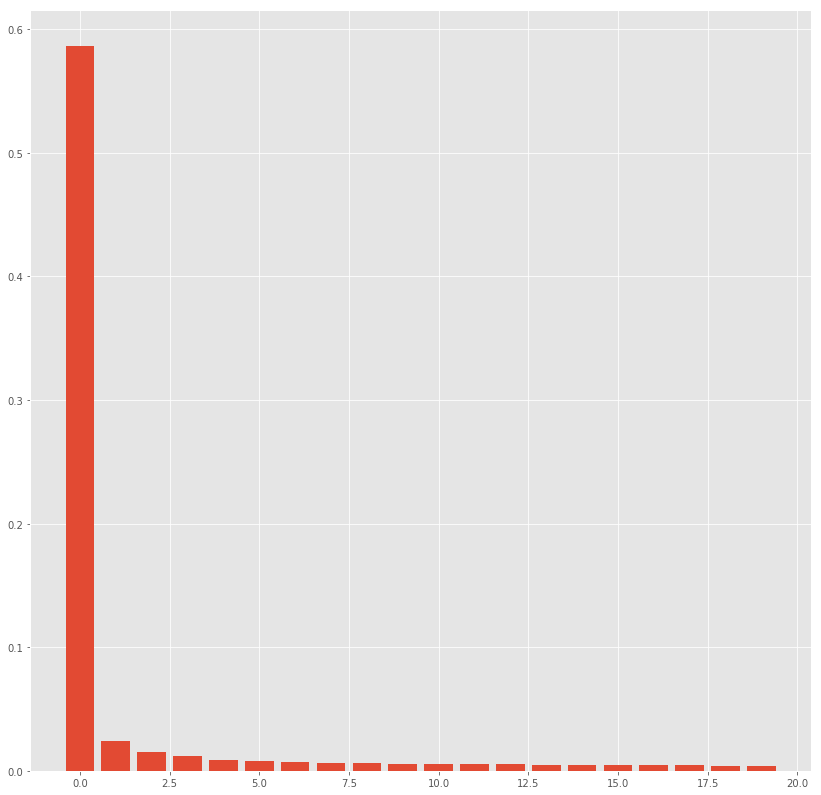

In [353]:
plt.bar(np.arange(risk_model.n_components), risk_model.pca.explained_variance_ratio_)

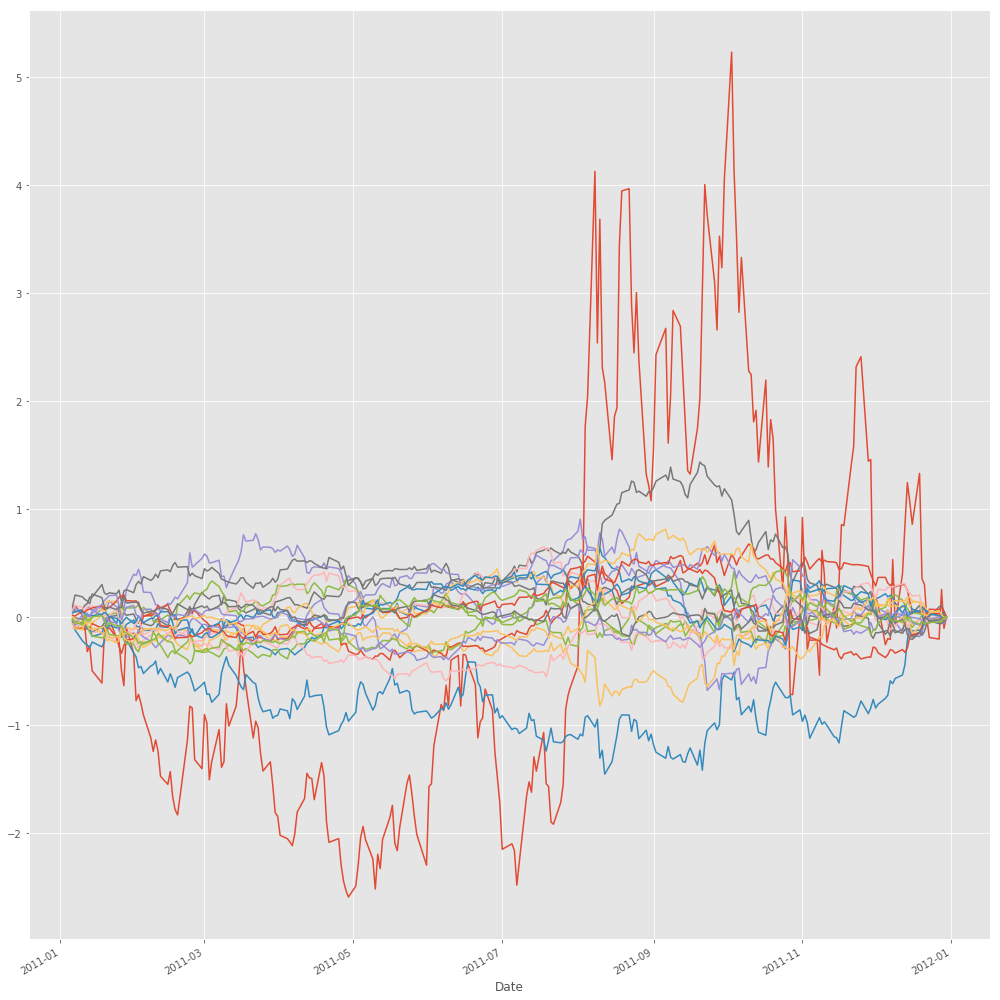

In [354]:
# looking at factor returns
risk_model.factor_returns.cumsum().plot(legend=False)
plt.tight_layout()

In [355]:
def density_plot(data): 
    density = gaussian_kde(data)
    xs = np.linspace(np.min(data),np.max(data),200)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    plt.plot(xs,density(xs))
    plt.xlabel('Daily Returns')
    plt.ylabel('Density')
    plt.show()

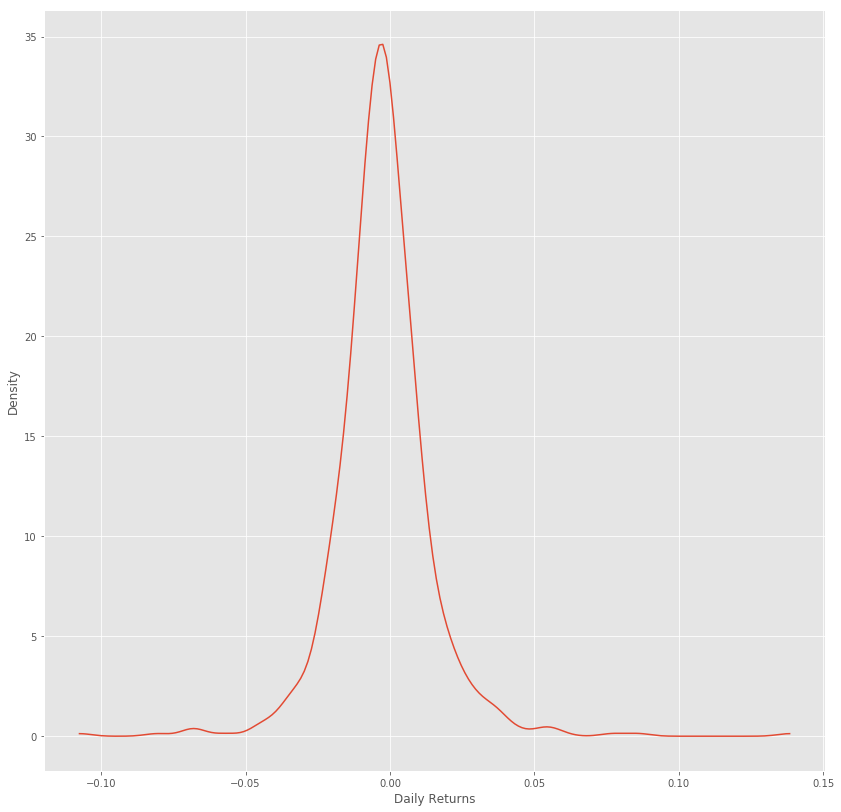

In [356]:
density_plot(risk_model.unwinz_returns.iloc[0])

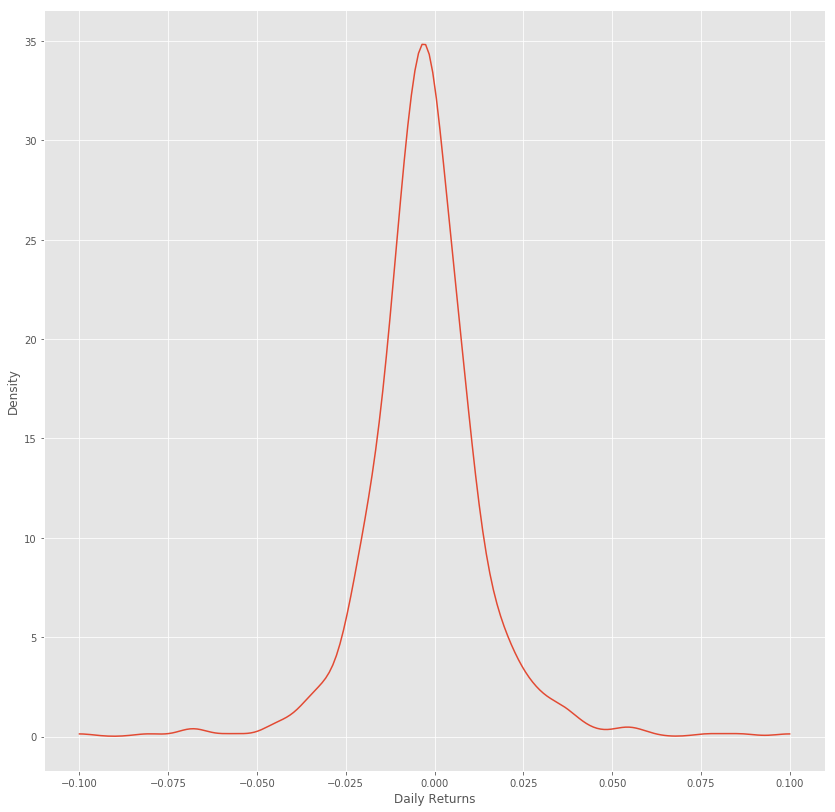

In [357]:
density_plot(risk_model.returns.iloc[0])

In [358]:
holdings = [50000000 / len(returns_2011.columns)] * len(returns_2011.columns)
holdings[:5]

[67476.38326585694,
 67476.38326585694,
 67476.38326585694,
 67476.38326585694,
 67476.38326585694]

In [359]:
risk_model.predict_portfolio_risk(holdings)

186099218691818.44

In [360]:
risk_model.predict_portfolio_risk_opt(holdings)

186099218691818.47

In [361]:
holdings = [1.0 / len(returns_2011.columns)] * len(returns_2011.columns)
holdings[:5]

[0.001349527665317139,
 0.001349527665317139,
 0.001349527665317139,
 0.001349527665317139,
 0.001349527665317139]

In [362]:
np.sqrt(risk_model.predict_portfolio_risk(holdings))

0.27283637491494306

In [363]:
np.sqrt(risk_model.predict_portfolio_risk_opt(holdings))

0.27283637491494295

In [364]:
def create_momentum_factor(prices, sector_data):

    # demean by sector
    df = prices.pct_change(252).dropna()
    sectors = sector_data.unique()
    
    # demean by sector
    for sector in sectors:
        col_filter = sector_data[sector_data==sector].index
        means = df.loc[:, col_filter].mean(axis=1)
        df.loc[:, col_filter] = df.loc[:, col_filter].subtract(means, axis=0)
        
    ranked = df.rank(axis=1, method='first')
    means = ranked.mean(axis=1)
    stds = ranked.std(axis=1)
    demeaned = ranked.subtract(means, axis=0)
    zscored = demeaned.div(stds, axis=0)
    return zscored

In [403]:
momentum = create_momentum_factor(p, sector_data)
momentum.head()

ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,PGR,WAT,NNN,IEX,LRCX,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-05,-0.471847,-1.326777,-0.228916,1.691173,-0.369068,1.588395,1.130563,0.728793,-1.200640,1.032457,...,0.261618,-0.686747,0.149496,-0.158839,-1.051144,1.621097,-1.130563,1.214655,0.126137,-0.172855
2012-01-06,-0.476518,-1.382838,-0.196213,1.686502,-0.583969,1.532334,1.130563,0.752152,-1.256701,1.027785,...,0.355053,-0.551266,0.219572,-0.182198,-1.004426,1.588395,-1.065159,1.275388,0.233587,-0.149496
2012-01-09,-0.513892,-1.448242,-0.294320,1.663143,-0.738136,1.513647,1.172609,0.752152,-1.130563,1.023113,...,0.327022,-0.537251,0.303664,-0.144824,-0.976396,1.588395,-1.027785,1.340792,0.154168,0.070076
2012-01-10,-0.551266,-1.508975,-0.163511,1.649128,-0.896976,1.555693,1.125892,0.569953,-1.191296,1.027785,...,0.415786,-0.560610,0.336366,-0.228916,-1.097861,1.522990,-1.069831,1.261372,0.116794,-0.004672
2012-01-11,-0.527908,-1.457586,-0.303664,1.649128,-0.873617,1.504303,1.083846,0.284977,-1.219327,1.018441,...,0.485862,-0.551266,0.355053,-0.228916,-1.079174,1.518319,-0.995083,1.331449,0.130809,-0.121465


In [404]:
momentum.tail()

ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,PGR,WAT,NNN,IEX,LRCX,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2015-12-29,-0.378412,-0.327022,-0.967052,-0.887632,1.401525,-1.471601,-1.139907,-0.682075,-0.854930,-0.803541,...,1.093189,0.042046,0.102778,0.397099,-0.317679,-1.294075,0.607327,1.051144,-0.467175,0.780182
2015-12-30,-0.406442,-0.551266,-0.990411,-0.840915,1.350136,-1.476273,-1.107205,-0.742808,-0.925006,-0.798869,...,1.107205,0.093435,0.140152,0.406442,-0.308335,-1.177281,0.509221,1.009098,-0.411114,0.780182
2015-12-31,-0.345709,-0.672732,-0.976396,-0.920335,1.373494,-1.476273,-1.130563,-0.682075,-0.910991,-0.794197,...,1.055815,0.158839,0.196213,0.387755,-0.266290,-1.195968,0.644701,1.032457,-0.397099,0.808213
2016-01-04,-0.401770,-0.747480,-0.981067,-0.719449,1.289403,-1.452914,-1.093189,-0.434473,-0.915663,-0.784854,...,1.060487,0.032702,0.200885,0.397099,-0.341038,-1.065159,0.649373,1.102533,-0.425129,0.794197
2016-01-05,-0.369068,-0.854930,-0.981067,-0.574625,1.317433,-1.448242,-1.102533,-0.317679,-0.910991,-0.798869,...,1.041800,-0.014015,0.102778,0.298992,-0.308335,-1.139907,0.565282,1.181953,-0.378412,0.850258


In [366]:
risk_model.returns.tail()

ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,PGR,WAT,NNN,IEX,LRCX,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2011-12-23,0.018753,-0.020237,0.011614,0.021882,-0.001494,0.001786,0.008702,0.024272,-0.005726,0.008050,...,0.011543,0.000939,0.000381,0.009111,0.004898,0.008929,0.013871,0.036691,0.016639,0.003724
2011-12-27,0.005956,-0.032746,-0.001218,0.012695,-0.004059,-0.002773,0.003299,0.008989,-0.002399,0.011224,...,0.010373,0.000402,0.013318,-0.008482,0.004874,0.006110,-0.001244,0.007106,-0.003195,0.005059
2011-12-28,-0.022605,-0.013021,-0.019680,-0.012450,-0.009119,-0.017680,-0.019558,-0.014253,-0.019243,-0.020704,...,-0.006673,-0.018226,-0.015020,-0.009106,-0.013743,0.002304,-0.005604,-0.015604,-0.007872,-0.003691
2011-12-29,0.004956,-0.005805,0.019009,0.018200,0.028328,0.001415,0.019430,0.011173,0.018476,0.023104,...,0.011886,0.012012,0.012581,0.029518,0.012295,0.012954,0.028178,-0.009786,0.016776,0.002021
2011-12-30,-0.009315,0.001592,-0.007148,-0.006480,0.001460,-0.017569,-0.005845,-0.008125,-0.004655,-0.004900,...,-0.003575,-0.001214,-0.006777,0.003787,-0.000810,0.001857,-0.016444,-0.000696,-0.006466,-0.011092


In [367]:
factor_data = {}
factor_data['momentum'] = momentum.loc[momentum.index.year==2015,:].stack()
factor_data['momentum'].head()
factor_prices = p.loc[p.index.year==2015, :]
print(factor_prices.shape)
print(factor_data['momentum'].shape)
factor_returns = al.utils.get_clean_factor_and_forward_returns(factor=factor_data['momentum'], prices=factor_prices, periods=[1])

(252, 741)
(186732,)
Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


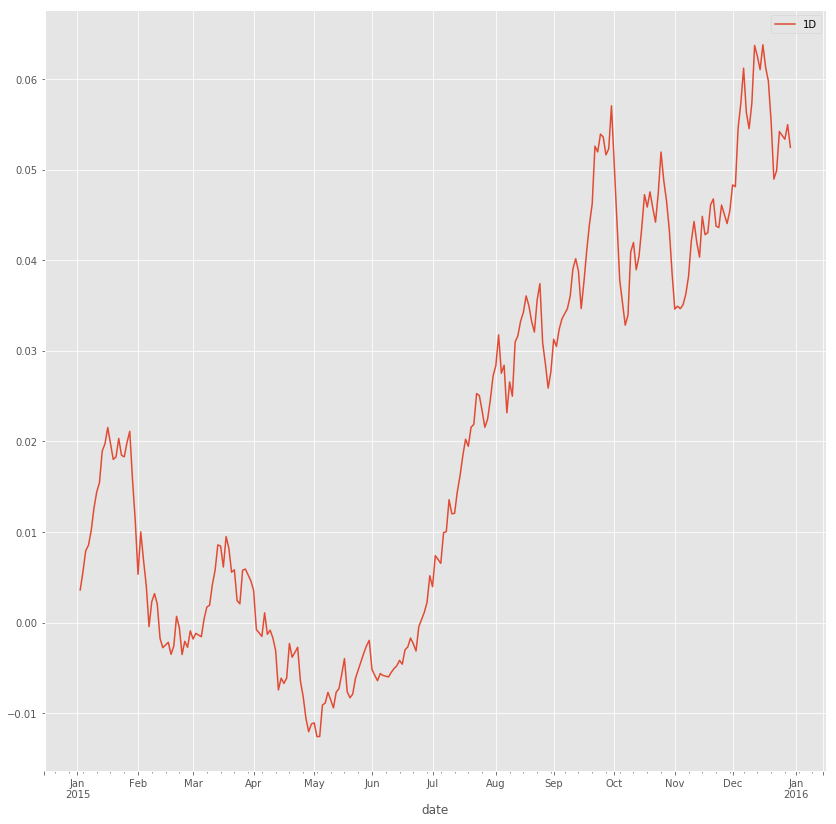

In [368]:
factor_returns_data = al.performance.factor_returns(factor_returns)
factor_returns_data.cumsum().plot()

In [369]:
sharpe = factor_returns_data.mean() * np.sqrt(252) / factor_returns_data.std()
sharpe

1D    1.295655
dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x150d864a8>,
      dtype=object)

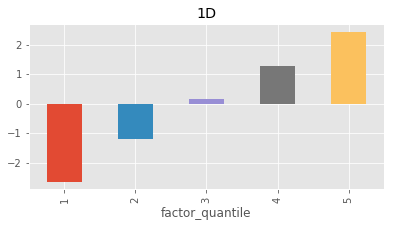

In [370]:

qr_factor_returns = al.performance.mean_return_by_quantile(factor_returns)[0].iloc[:, 0]

(10000*qr_factor_returns).plot.bar(
    subplots=True,
    sharey=True,
    layout=(4,2),
    figsize=(14, 14),
    legend=False)

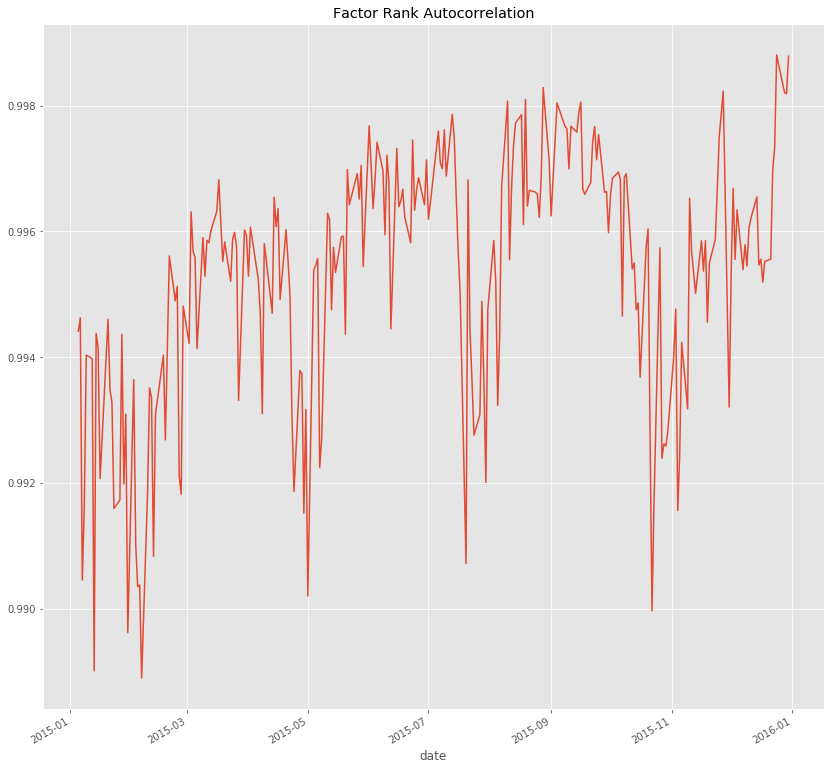

In [371]:
ls_FRA = al.performance.factor_rank_autocorrelation(factor_returns)

ls_FRA.plot(title="Factor Rank Autocorrelation")

In [372]:
alpha_vector = momentum.loc['2012-01-05', :]
len(alpha_vector)

741

In [373]:
previous = np.asarray(holdings)
len(previous)

741

In [761]:
class OptimalHoldingsCVX:

    def __init__(self, risk_model, alpha_vector, previous, risk_cap=0.02, factor_max=10.0, aum=50e6, lambda_reg=0.50,
                 factor_min=-10.0, weights_max=0.015, weights_min=-0.015, risk_aversion=1.0e-6):

        self.risk_model = risk_model
        self.alpha_vector = alpha_vector
        self.previous = previous
        self.risk_cap = risk_cap * aum
        self.factor_min = factor_min 
        self.factor_max = factor_max
        self.weights_min = weights_min * aum
        self.weights_max = weights_max * aum
        self.risk_aversion = risk_aversion
        self.aum = aum
        self.lambda_reg = lambda_reg

    def _get_obj(self):
        start = time.time()
        ra = self.risk_aversion
        Q = self.risk_model.Q # Q is k x N
        ivv = self.risk_model.i_var_vector
        av = -self.alpha_vector.values.reshape(len(self.alpha_vector), 1)
        h0 = self.previous.flatten()
        lv = np.ones((len(av), 1)) * 0.1/2000000
        h1 = cvx.Variable(len(self.alpha_vector))
        m = ra * 0.50
        #func = m * cvx.sum((Q @ h1)**2) + m * ((h1**2) @ ivv) - (h1 @ av) + ((h1-h0)**2) @ lv + self.lambda_reg * cvx.norm(h1, 2)
        func = (h1 @ av) + self.lambda_reg * cvx.norm(h1, 2) + ((h1-h0)**2) @ lv
        obj_func = cvx.Minimize(func)
        self.is_dcp = cvx.Problem(obj_func, []).is_dcp()
        print(self.is_dcp)
        self.h1 = h1
        self.obj_func = obj_func
        end = time.time()
        print('get_obj took: ', end-start)
        return

    def _get_constraints(self):
        start = time.time()
        risk = self.get_risk()
        c = []
        h1 = self.h1
        factor_exposures = self.risk_model.factor_exposures
        c.append(risk <= self.risk_cap**2)
        c.append(h1 <= self.weights_max)
        c.append(h1 >= self.weights_min)
        c.append(sum(h1) == 0)
        c.append(factor_exposures.T @ h1 <= self.factor_max)
        c.append(factor_exposures.T @ h1 >= self.factor_min)
        c.append(sum(cvx.abs(h1)) <= self.aum)
        end = time.time()
        print('get_constraints took: ', end-start)
        return c

    def get_risk(self):
        start = time.time()
        Q = self.risk_model.Q
        h1 = self.h1
        ivv = self.risk_model.i_var_vector
        #result = cvx.sum((Q @ h1)**2) + (h1**2) @ ivv
        ivm = self.risk_model.i_var_matrix.values
        f = self.risk_model.factor_exposures.T @ h1
        X = self.risk_model.factor_cov_matrix
        end = time.time()
        print('get_risk took: ', end-start)
        #return result
        return cvx.quad_form(f, X) + cvx.quad_form(h1, ivm)

    def find(self):
        self._get_obj()
        h1 = self.h1
        prob = cvx.Problem(self.obj_func, self._get_constraints())
        start = time.time()
        print(prob.is_dcp())
        prob.solve(max_iters=100, verbose=True, solver=cvx.SCS)
        optimal_weights = np.asarray(h1.value).flatten()
        df = pd.DataFrame(optimal_weights, index=self.alpha_vector.index)
        end = time.time()
        print('find took: ', end-start)
        return df

In [538]:
oh = OptimalHoldingsCVX(risk_model, alpha_vector, previous, lambda_reg=0.0)

In [539]:
oh._get_obj()
oh.obj_func

True
get_obj took:  0.001065969467163086


Minimize(Expression(CONVEX, UNKNOWN, (1,)))

In [377]:
risk_model.Q.shape

(20, 741)

In [378]:
oh.get_risk()

get_risk took:  0.0032379627227783203


Expression(CONVEX, NONNEGATIVE, (1, 1))

In [379]:
result = oh.find()

True
get_obj took:  0.0006608963012695312
get_risk took:  0.0006711483001708984
get_constraints took:  0.06892800331115723
True
find took:  43.18056893348694


In [380]:
result.shape

(741, 1)

/Users/richard.wuebker/.pyenv/versions/zipline/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


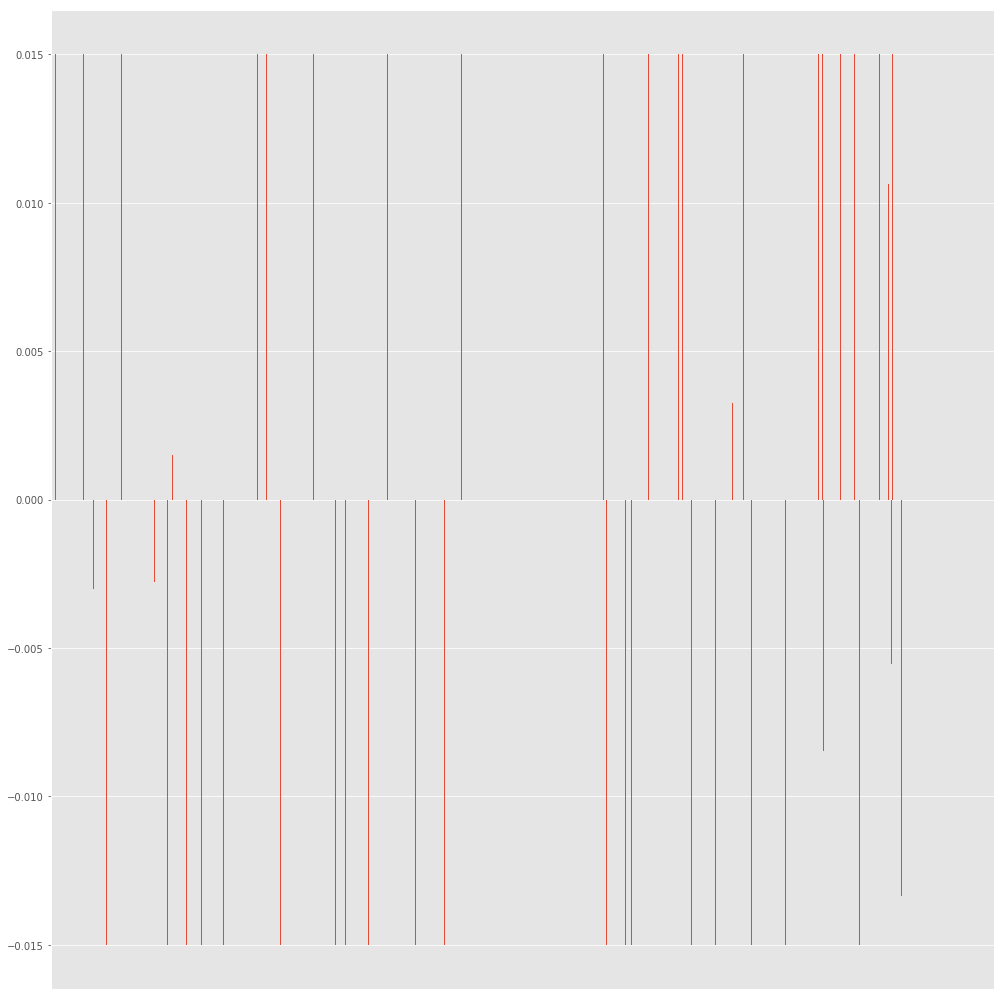

In [381]:
(result).plot.bar(legend=False)
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)
plt.tight_layout()
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)

In [382]:
oh = OptimalHoldingsCVX(risk_model, alpha_vector, previous, lambda_reg=1.0)
oh._get_obj()

True
get_obj took:  0.0009300708770751953


True
get_obj took:  0.0007319450378417969
get_risk took:  0.0007500648498535156
get_constraints took:  0.07487201690673828
True
find took:  43.263259172439575


/Users/richard.wuebker/.pyenv/versions/zipline/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


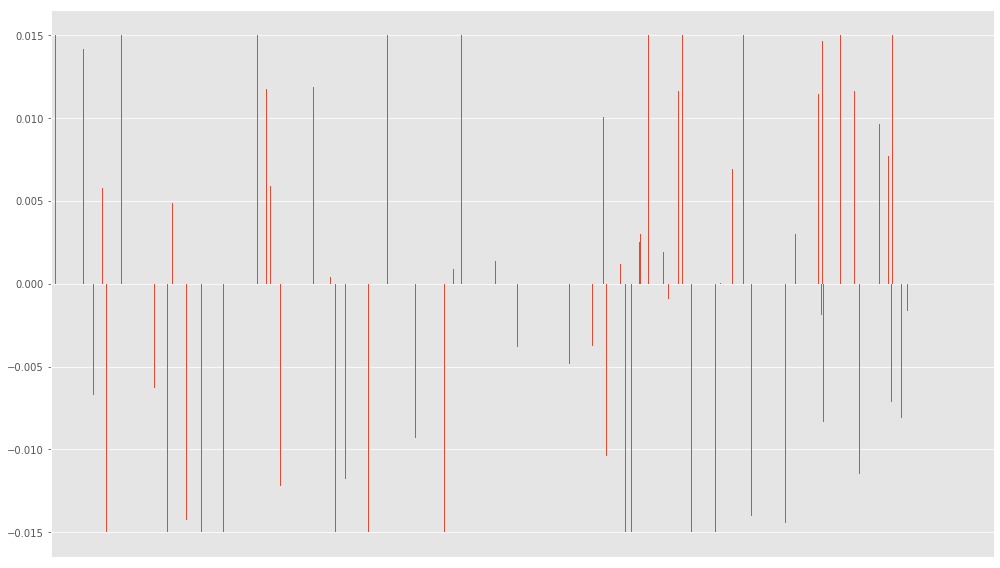

In [383]:
result = oh.find()
(result).plot.bar(legend=False)
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)
plt.tight_layout()

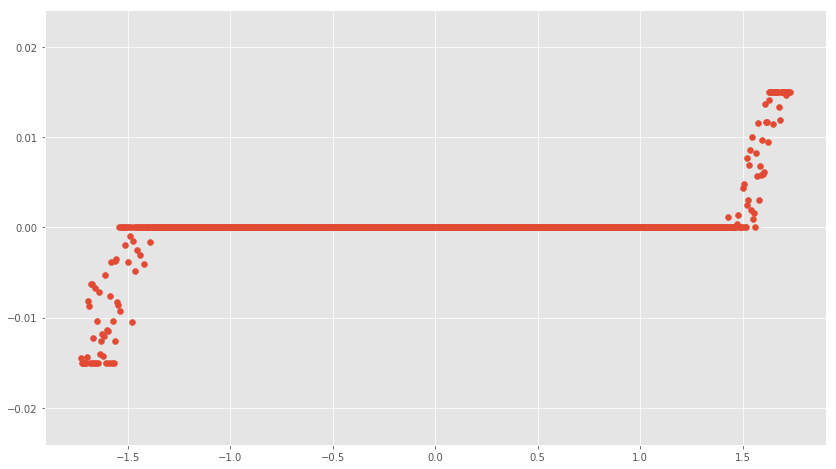

In [384]:
plt.scatter(oh.alpha_vector, result)

In [385]:
print(len(alpha_vector))
print(len(result))
print(alpha_vector.head())
print(result.head())

741
741
ticker
CSCO   -0.471847
UAL    -1.326777
TROW   -0.228916
ISRG    1.691173
NVR    -0.369068
Name: 2012-01-05 00:00:00, dtype: float64
                   0
ticker              
CSCO    1.299243e-11
UAL     3.571340e-11
TROW    5.238610e-12
ISRG    1.500000e-02
NVR     1.065189e-11


In [386]:
def get_transfer_coefficient(a, b):
    tc, p = pearsonr(a, b)
    return tc

In [387]:
av = alpha_vector.values
r = result.values.flatten()
print(av.shape)
print(r.shape)

(741,)
(741,)


In [388]:
get_transfer_coefficient(av, r)

0.5412499606494473

In [412]:
initial_holdings = np.ones((len(alpha_vector), 1))  / len(alpha_vector)
print(initial_holdings.shape)
initial_holdings[:5]


(741, 1)


array([[0.00134953],
       [0.00134953],
       [0.00134953],
       [0.00134953],
       [0.00134953]])

In [424]:
test_period = momentum.loc[momentum.index.year==2015,:].index[:1]
print(test_period)
for d in test_period:
    print('hello')

DatetimeIndex(['2015-01-02'], dtype='datetime64[ns]', name='Date', freq=None)
hello


In [667]:
def backtest(test_period, holdings, returns, alpha, aum):
    port = {}
    
    print('this is test_period: ', list(test_period))
    for d in test_period:
        str_d = d.strftime('%Y%m%d')
        end_date = d
        start_date = d - dt.timedelta(days=365)
        av = alpha.loc[end_date, :]
        rets = returns.loc[start_date:end_date, :]
        lambda_vector = np.ones((1, len(av))) * 0.1/2000000
        rm = RiskModelPCA(rets, 20)
        start = time.time()
        oh = OptimalHoldingsCVX(rm, av, holdings, lambda_reg=1.0, aum=aum)
        end = time.time()
        start = time.time()
        new_holdings = oh.find()
        end = time.time()
        print('this is lambda_vector shape: ', lambda_vector.shape)
        print('old holdings shape: ', holdings.shape)
        print('new holdings shape: ', new_holdings.shape)
        print('alpha vector shape: ', av.shape)
        print('this is type of alpha vector: ', type(av))
        print('risk factors shape: ', rm.factor_exposures.shape)
        print('factor exposures columns: ', rm.factor_exposures.columns.shape)
        data = np.matmul(rm.factor_exposures.values.T, new_holdings.values).flatten()
        print(data)
        risk_exposures = pd.Series(data=data.T, index=rm.factor_exposures.columns.values) * aum
        alpha_exposures = pd.Series(np.matmul(av.T, new_holdings), index=av.index) * aum
        transaction_costs = np.dot(lambda_vector, (new_holdings - holdings)**2).flatten() * aum
        result = {
            'h.opt.previous': np.nan_to_num(holdings).flatten(),
            'h.opt': np.nan_to_num(new_holdings).flatten(),
            'risk.exposures': risk_exposures,
            'alpha.exposures': alpha_exposures,
            't.costs': transaction_costs,
            'factor.returns': rm.factor_returns
        }
        port[str_d] = result
        holdings = new_holdings
    return port

In [762]:
test_period = momentum.loc[momentum.index.year==2015].index[:1]
initial_holdings = np.zeros((len(momentum.columns), 1))
#initial_holdings = np.zeros((len(alpha_vector), 1))  / len(alpha_vector)
print(initial_holdings.shape)
port = backtest(test_period, initial_holdings, returns, momentum, 50000000)

(741, 1)
this is test_period:  [Timestamp('2015-01-02 00:00:00')]
True
get_obj took:  0.001123189926147461
get_risk took:  0.00030612945556640625
get_constraints took:  0.08597993850708008
True
----------------------------------------------------------------------------
	SCS v2.1.1 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 2247460
eps = 1.00e-04, alpha = 1.50, max_iters = 100, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 550566, constraints m = 1103417
Cones:	primal zero / dual free vars: 1
	linear vars: 1099686
	soc vars: 3730, soc blks: 744
Setup time: 3.47e+00s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 9.

/Users/richard.wuebker/.pyenv/versions/zipline/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


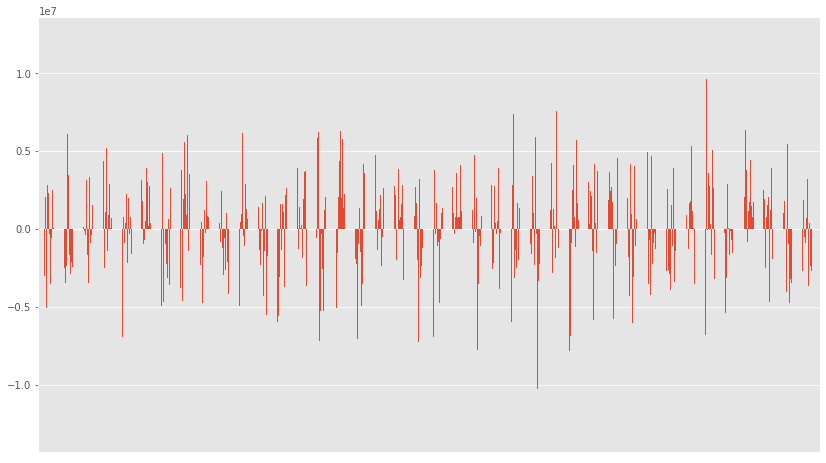

In [763]:
holdings = pd.DataFrame(port['20150102']['h.opt'], index=momentum.columns, columns=['holdings'])
holdings.plot.bar(legend=False)
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)

In [764]:
holdings['holdings'].sum()

-2807699.6690933295

In [526]:
def build_attribution(port, returns, alpha, factor_returns, date_index):
    df = pd.DataFrame(index=date_index)
    
    for date_ in date_index:
        date_str = date_.strftime('%Y%m%d')
        
        p = port[date_str]
        
    
    pass

test_period = momentum.loc[momentum.index.year==2015].index[:10]
test_period

DatetimeIndex(['2015-01-02', '2015-01-05', '2015-01-06', '2015-01-07',
               '2015-01-08', '2015-01-09', '2015-01-12', '2015-01-13',
               '2015-01-14', '2015-01-15'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [316]:
get_transfer_coefficient(port['20150105']['h.opt'], momentum.loc['20150105',:].values)

0.5446562201774551

In [317]:
port['20150105']['h.opt'].shape

(741,)

In [527]:
returns.head()

ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,PGR,WAT,NNN,IEX,LRCX,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-06,0.008666,0.015779,0.000000,-0.018090,0.037116,0.045433,-0.007356,0.006471,-0.005972,-0.003648,...,-0.008942,-0.022368,-0.018391,0.000519,0.000635,0.002047,0.002190,-0.016205,-0.010781,-0.007082
2011-01-07,0.000954,0.007767,-0.008134,-0.004764,0.023316,-0.002120,0.000303,-0.000946,0.002939,0.016846,...,-0.010526,-0.011045,-0.009368,-0.003628,-0.001903,0.003064,-0.012568,-0.019949,-0.008266,-0.009384
2011-01-10,-0.008583,0.009634,0.001548,0.015632,0.020146,0.005463,0.011035,0.012493,-0.002039,0.003842,...,-0.022290,-0.007047,-0.011032,0.006502,0.032627,0.021725,0.000554,0.031186,0.014918,-0.001516
2011-01-11,0.004328,-0.019466,0.007415,0.034649,0.002587,0.008603,0.024671,0.009348,0.032695,0.004783,...,-0.001554,0.021693,-0.009960,0.005168,0.015183,-0.003987,-0.011615,-0.015031,0.011770,0.000759
2011-01-12,0.011494,0.008174,0.021469,0.004342,0.018779,-0.010175,0.002043,0.005927,0.013975,0.014044,...,-0.002076,0.005898,-0.003622,0.013419,0.014956,0.006004,0.019026,0.011583,0.002171,0.008722


In [529]:
returns.shift(-2).head()

ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,PGR,WAT,NNN,IEX,LRCX,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-06,-0.008583,0.009634,0.001548,0.015632,0.020146,0.005463,0.011035,0.012493,-0.002039,0.003842,...,-0.022290,-0.007047,-0.011032,0.006502,0.032627,0.021725,0.000554,0.031186,0.014918,-0.001516
2011-01-07,0.004328,-0.019466,0.007415,0.034649,0.002587,0.008603,0.024671,0.009348,0.032695,0.004783,...,-0.001554,0.021693,-0.009960,0.005168,0.015183,-0.003987,-0.011615,-0.015031,0.011770,0.000759
2011-01-10,0.011494,0.008174,0.021469,0.004342,0.018779,-0.010175,0.002043,0.005927,0.013975,0.014044,...,-0.002076,0.005898,-0.003622,0.013419,0.014956,0.006004,0.019026,0.011583,0.002171,0.008722
2011-01-11,-0.001894,0.002317,0.001952,-0.010985,0.014608,0.000151,0.000291,-0.008102,-0.000610,-0.006807,...,-0.003640,-0.004691,0.003635,-0.006366,0.003584,0.008952,-0.023613,0.008179,0.010163,-0.032707
2011-01-12,0.006167,-0.003082,0.014384,0.032854,0.026724,0.013604,0.001893,0.009467,0.010374,0.017017,...,0.016179,0.000655,-0.001610,0.011789,0.045436,0.017746,-0.001125,0.014963,0.016598,-0.003109
